# Modules

In [25]:
import pandas as pd
from urllib import request
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


# Data Processing

In [2]:
df_json = pd.read_json('Indian_Number_plates.json', lines=True)
df_json.head()

,annotation,content,extras,metadata
0,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1530954577000, 'last_updated..."
1,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1530954866000, 'last_updated..."
2,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1530971844000, 'last_updated..."
3,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1530971917000, 'last_updated..."
4,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1530955094000, 'last_updated..."


In [3]:
dataset = {'image_name':list(),
           'top_x':list(),
           'top_y':list(),
           'bottom_x':list(),
           'bottom_y':list(),
           'image_width':list(),
           'image_height':list()}

In [4]:
num=1
for i, row in df_json.iterrows():
    url = row['content']
    img = request.urlopen(url)
    img = Image.open(img)
    img = img.convert('RGB')
    img.save('Data/{}.jpeg'.format(num), 'JPEG')
    dataset['image_name'].append(str(num)+'.jpeg')
    
    annot = row['annotation'][0]
    dataset['image_width'].append(annot['imageWidth'])
    dataset['image_height'].append(annot['imageHeight'])
    dataset['top_x'].append(annot['points'][0]['x'])
    dataset['top_y'].append(annot['points'][0]['y'])
    dataset['bottom_x'].append(annot['points'][1]['x'])
    dataset['bottom_y'].append(annot['points'][1]['y'])
    
    num += 1

In [5]:
df = pd.DataFrame(dataset)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y,image_width,image_height
0,1.jpeg,0.722084,0.587983,0.868486,0.688841,806,466
1,2.jpeg,0.161943,0.850780,0.582996,1.000000,494,449
2,3.jpeg,0.082000,0.697452,0.230000,0.828025,500,314
3,4.jpeg,0.434000,0.667377,0.718000,0.765458,500,469
4,5.jpeg,0.208791,0.390764,0.865135,0.984014,1001,563


In [6]:
df.to_csv('dataset.csv', index=False)

In [7]:
df = pd.read_csv('dataset.csv')
df.drop(['image_width', 'image_height'], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,1.jpeg,0.722084,0.587983,0.868486,0.688841
1,2.jpeg,0.161943,0.850780,0.582996,1.000000
2,3.jpeg,0.082000,0.697452,0.230000,0.828025
3,4.jpeg,0.434000,0.667377,0.718000,0.765458
4,5.jpeg,0.208791,0.390764,0.865135,0.984014


In [9]:
test_samples = np.random.randint(0, len(df), 5)
df_train = df.drop(test_samples, axis=0)

In [18]:
def show_image(index):
    img = cv2.imread('Data/' + df['image_name'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(224,224))
    
    tx = int(df['top_x'].iloc[index] * 224)
    ty = int(df['top_y'].iloc[index] * 224)
    bx = int(df['bottom_x'].iloc[index] * 224)
    by = int(df['bottom_y'].iloc[index] * 224)
    
    img = cv2.rectangle(img, (tx, ty), (bx, by), (255,0,0), 1)
    plt.imshow(img)
    plt.show()

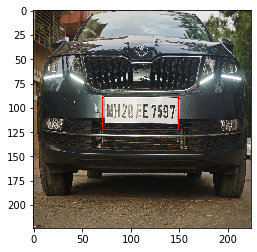

In [22]:
show_image(34)

# Model

In [27]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df_train,
    directory="Data/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(224, 224),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df_train,
    directory="Data/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(224, 224),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 280 images.
Found 31 images.


In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [29]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [35]:
for layer in base_model.layers:
    layer.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [42]:
train_step_size = int(np.ceil(train_generator.n / train_generator.batch_size))
val_step_size = int(np.ceil(validation_generator.n / validation_generator.batch_size))

train_generator.reset()
validation_generator.reset()

In [43]:
print(train_step_size, val_step_size)

9 1


# Training

In [44]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

In [45]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=train_step_size,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=val_step_size)

Epoch 1/30
9/9 [==============================] - 41s 5s/step - loss: 0.0356 - acc: 0.4910 - val_loss: 0.0206 - val_acc: 0.7097
Epoch 2/30
9/9 [==============================] - 12s 1s/step - loss: 0.0141 - acc: 0.7451 - val_loss: 0.0145 - val_acc: 0.6129
Epoch 3/30
9/9 [==============================] - 21s 2s/step - loss: 0.0066 - acc: 0.8343 - val_loss: 0.0122 - val_acc: 0.7419
Epoch 4/30
9/9 [==============================] - 21s 2s/step - loss: 0.0039 - acc: 0.8635 - val_loss: 0.0108 - val_acc: 0.7419
Epoch 5/30
9/9 [==============================] - 21s 2s/step - loss: 0.0025 - acc: 0.8973 - val_loss: 0.0110 - val_acc: 0.7742
Epoch 6/30
9/9 [==============================] - 14s 2s/step - loss: 0.0016 - acc: 0.9283 - val_loss: 0.0112 - val_acc: 0.8065
Epoch 7/30
9/9 [==============================] - 13s 1s/step - loss: 0.0010 - acc: 0.9318 - val_loss: 0.0104 - val_acc: 0.8065
Epoch 8/30
9/9 [==============================] - 13s 1s/step - loss: 6.9809e-04 - acc: 0.9377 - val_los

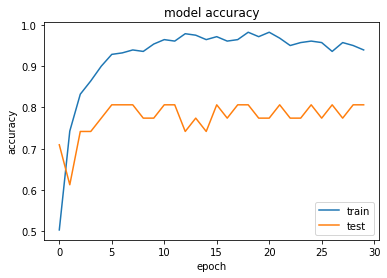

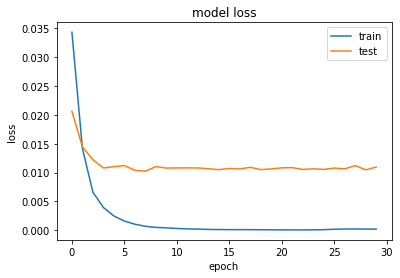

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


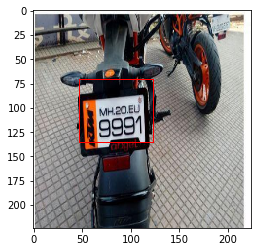

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


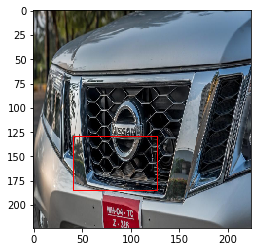

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


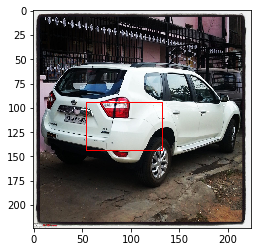

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


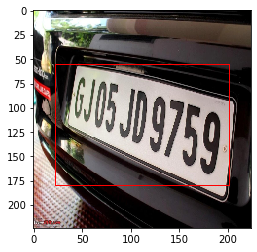

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


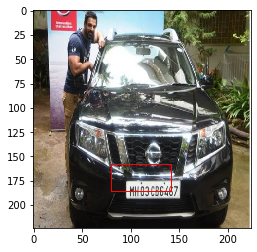

In [48]:
for i, row in df.iloc[test_samples].iterrows():
    img = cv2.imread('Data/' + row[0])
    img = cv2.resize(img/255.0, dsize=(224,224))
    
    y_pred = model.predict(img.reshape(1, 224, 224, 3)).reshape(-1) * 224
    
    x_top, y_top, x_bottom, y_bottom = y_pred[0], y_pred[1], y_pred[2], y_pred[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (x_top, y_top), (x_bottom, y_bottom), (255,0,0), 1)
    plt.imshow(img)
    plt.show()